# Setup
It's no secret that i love pytorch because of the FastAI library, let's get it set up!

In [18]:
!pip install -q --upgrade fastcore fastai

# Dataloaders and such
Gettig the data ready - luckily it's fairly easy thanks to fastai.

Import everything in FastAI vision, of course, this is a bad idea in production code.

In [19]:
from fastai.vision.all import *

In [20]:
 def random_seed(seed_value, use_cuda): 
    np.random.seed(seed_value)
 #cpu vars
    torch.manual_seed(seed_value) 
# cpu  vars
    random.seed(seed_value)
 # Python 
    if use_cuda: 
        torch.cuda.manual_seed(seed_value) 
        torch.cuda.manual_seed_all(seed_value) 
# gpu vars
        torch.backends.cudnn.deterministic = True 
 #needed
        torch.backends.cudnn.benchmark = False 
#Remember to use num_workers=0 when creating the DataBunch.

In [21]:
random_seed(2021,True) #i'm using seed 2021

Bring in the Dataset csv files using pandas library, pandas came when I imported everything in Fastai.vision

In [22]:
train = pd.read_csv('/kaggle/input/road-segmentation-identification/Train.csv')
train.head()

,Image_ID,Target
0,ID_0073qfb8,0
1,ID_00gy3vH2,1
2,ID_00uB3UFr,0
3,ID_012xZpNw,1
4,ID_014GgMRb,1


In [23]:
train.Target.value_counts()

Target
1    3771
0    3229
Name: count, dtype: int64

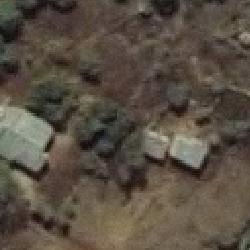

In [24]:
Image.open('/kaggle/input/road-segmentation-identification/Images/Images/ID_0073qfb8.tif')

Use Fastai Data Api block to load the dataset, note that I used a stratified split for train and validation

In [25]:
road = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    splitter=TrainTestSplitter(0.1, stratify=train["Target"]),
  get_x = ColReader(0),
    get_y=ColReader(1))

The train set contains image IDs, for FastAI to get the image I did some manipulations to complete it as a path. There are better ways to do this, however, they may not come to you in the heat of the hack, lol.

In [26]:
train.Image_ID = ["/kaggle/input/road-segmentation-identification/Images/Images/"+i+".tif" for i in train.Image_ID]

Quick head view.

In [27]:
train.head()

,Image_ID,Target
0,/kaggle/input/road-segmentation-identification/Images/Images/ID_0073qfb8.tif,0
1,/kaggle/input/road-segmentation-identification/Images/Images/ID_00gy3vH2.tif,1
2,/kaggle/input/road-segmentation-identification/Images/Images/ID_00uB3UFr.tif,0
3,/kaggle/input/road-segmentation-identification/Images/Images/ID_012xZpNw.tif,1
4,/kaggle/input/road-segmentation-identification/Images/Images/ID_014GgMRb.tif,1


Next here, we create the dataloader, I used a very small batch size here, so that I could make the gradient steps move smaller, hence get that sweet spot for a good test & valid accuracy.

In [28]:
dls = road.dataloaders(train, bs=8)

/opt/conda/lib/python3.10/site-packages/fastai/data/transforms.py:212: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  o = r[c] if isinstance(c, int) or not c in getattr(r, '_fields', []) else getattr(r, c)


Check out a minibatch before we proceed.

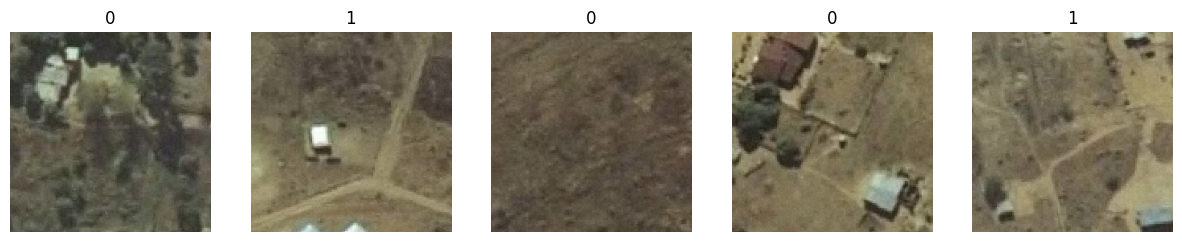

In [29]:
dls.train.show_batch(max_n=5, nrows=1)

# Training the Model
Bring in models from Pytorch's pretrained bunch of models
Actually, we could have achieved this without having to pull from pytorch, Personally I wanted to check out the performance of mobilenet, and a bunch of others just by switching the name alone. You can add it to your bag of tricks! It's a smart move.

So I picked the Densenet161 for my final solution, and used error_rate to measure the model performance. Don't be confused, I cut the last layer which contains the imagenet classes

In [30]:
import torchvision.models as models
learn = cnn_learner(dls, models.densenet161, cut=-1,metrics=error_rate)
#learn.lr_find()

/opt/conda/lib/python3.10/site-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth
100%|██████████| 110M/110M [00:00<00:00, 129MB/s]  


- Train the model

I only trained the model for 3 epochs, notice how magnificiently well the error rate reduced during the 3rd epoch, It's amazing!


- Don't forget to mixup!!

So now you've noticed we didn't do any data augumentation while creating the data loader, that's because I intended to land it with mixup. What mixup basically does is to combine pictures together, it could be same classes or even different classes and learn to identify by how much different they are, this is a good idea for road segmentation where the images look very much alike, you'll need to hold both images side by side to spot the difference.

In [31]:
learn.fine_tune(3, cbs=MixUp(0.2))

epoch,train_loss,valid_loss,error_rate,time
0,0.618597,0.381483,0.171429,02:43


epoch,train_loss,valid_loss,error_rate,time
0,0.532640,0.381465,0.170000,03:39
1,0.470415,0.346607,0.127143,03:38
2,0.351721,0.265105,0.110000,03:39


# Making and Saving Predictions
We make a test dataloader, get the predicted probabilities and shape them into the format Zindi wants. I hope this sort of makes sense :)

In [32]:
# Load the test data
test = pd.read_csv('/kaggle/input/road-segmentation-identification/Test.csv')
test.head(3)

,Image_ID
0,ID_01c6i2wd
1,ID_03sPqBLY
2,ID_06ZKUQFl


In [33]:
# Check format
ss = test.copy()
ss.head(3)

,Image_ID
0,ID_01c6i2wd
1,ID_03sPqBLY
2,ID_06ZKUQFl


### Use TTA
It's a good idea to use TTA, this helps to improve score.

In [35]:
# Make a test dataloader and get predictions
tdl = learn.dls.test_dl(test['Image_ID'].map(lambda s: '/kaggle/input/road-segmentation-identification/Images/Images/'+s+'.tif').values)
test_preds_tta, test_labels_tta = learn.tta(dl=tdl)
preds = [p[1] for p in test_preds_tta.numpy()]

Check Out a single Prediction



In [36]:
preds[0]

0.1058632

In [37]:
# Store the predicted probabilities (we want P(Target=1))
test['Target'] =preds #[float(p[1]) for p in preds[0]]
test.head()

,Image_ID,Target
0,ID_01c6i2wd,0.105863
1,ID_03sPqBLY,0.043045
2,ID_06ZKUQFl,0.998188
3,ID_06gzqIwK,0.020028
4,ID_08kWat36,0.099726


In [ ]:
name = "submission.csv"
test.to_csv(name, index=False)